In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
import time

# Import the MFI library 
import MFI_lib2D as lib2
import MFI_class2D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_convergence_analysis/pot1/"): print("\nThe data folder \"_data_convergence_analysis/pot1/\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_convergence_analysis/pot1/"); 
    path_data = path_notebook + "/_data_convergence_analysis/pot1/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class2D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_convergence_analysis/pot1/


### Define Potential and default parameters

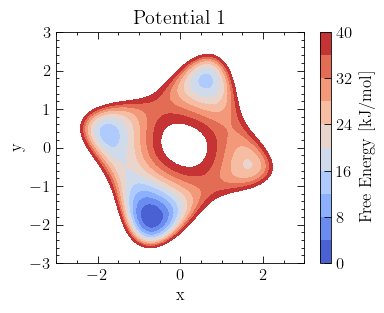

In [2]:
# Define the grid, the potential, the string of the potential and the FES cutoff
grid = np.linspace(-3, 3, 100); 
X, Y = np.meshgrid(grid, grid)
pot1 = 3.9*X**4 + 3.9*Y**4 - 19.2*X**2 - 19.2*Y**2 + 5.7*X**3*Y - 5.7*X*Y**3 + 12*X**2*Y**2 - 6*X*Y + 2.7*Y + 3.6*X
pot1 = pot1 - np.min(pot1)
dpot1_dy, dpot1_dx = np.gradient(pot1, grid, grid)
pot1_string = "3.9*x^4+3.9*y^4-19.2*x^2-19.2*y^2+5.7*x^3*y-5.7*x*y^3+12*x^2*y^2-6*x*y+2.7*y+3.6*x"
plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x,p.y FUNC=({pot1_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
FES_cutoff = 40

# Define plumed grid
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, [-4,-4], [4,4])

# plot the free energy surface
plt.contourf(X, Y, pot1, levels=np.linspace(0, FES_cutoff, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Potential 1"); plt.show()


In [3]:
# default parameters for the MFI class
default_params = {  "X":X, "Y":Y, "Z":pot1, "bw":[0.1, 0.1], #"dZ_dX":dpot1_dx, "dZ_dY":dpot1_dy,
                    "System":"Langevin", "plumed_dat_text":plumed_dat_text, "plX":plX, "plY":plY, "simulation_steps":1_500_000, 
                    "position_pace":20, "n_pos_per_window":10, "metad_pace":200, 
                    "metad_width":[0.1, 0.1], "metad_height":2, "biasfactor":20,
                    "Bias_sf":1, "gaus_filter_sigma":None,
                    "len_error_list":100,
                    "FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":50, "record_forces_e":True, "save_error_progression":False,
                    "simulation_folder_path": path_data, "print_info": False}

### Run 100 Long simulation for reference

In [18]:
# Run 100 long simulations
long_sim_params = {**default_params}
long_sim_params.update({"save_error_progression":True})#, "n_pos":50_000})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1, 101):
    
    sim_ID = f"_long_{i_sim}"
    long_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_long = MFI_class2D.MFI2D(**long_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_long.run_simulation()
        MFI_long.analyse_data()
        t, aofe, aad, aBS = MFI_long.Avr_Error_list[:,0], MFI_long.Avr_Error_list[:,2], MFI_long.Avr_Error_list[:, MFI_long.aad_index], MFI_long.Avr_Error_list[:, MFI_long.abs_error_index]
        
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 3 | Final Error: Aofe = 1.1626, AAD = 1.0183, ABS = 0.5576
Simulation 4 | Final Error: Aofe = 1.1602, AAD = 1.2037, ABS = 0.4745
Simulation 5 | Final Error: Aofe = 1.1561, AAD = 1.3557, ABS = 0.5570
Simulation 6 | Final Error: Aofe = 1.1538, AAD = 0.8163, ABS = 0.5135
Simulation 7 | Final Error: Aofe = 1.1635, AAD = 1.1571, ABS = 0.5997
Simulation 8 | Final Error: Aofe = 1.1601, AAD = 0.8927, ABS = 0.5210
Simulation 9 | Final Error: Aofe = 1.1614, AAD = 1.1863, ABS = 0.4755
Simulation 10 | Final Error: Aofe = 1.1676, AAD = 1.1727, ABS = 0.4524
Simulation 11 | Final Error: Aofe = 1.1810, AAD = 1.4178, ABS = 0.3652
Simulation 12 | Final Error: Aofe = 1.1665, AAD = 1.1992, ABS = 0.5713
Simulation 13 | Final Error: Aofe = 1.1418, AAD = 0.7997, ABS = 0.5862
Simulation 14 | Final Error: Aofe = 1.1544, AAD = 0.8358, ABS = 0.6134
Simulation 15 | Final Error: Aofe = 1.1451, AAD = 0.5799, ABS = 0.5253
Simulation 16 | Final Error: Aofe = 1.1752, AAD = 1.0580, ABS = 0.4842
Simulation 17

Mean Final AAD: 1.0834 +- 0.0203 || Mean Final ABS: 0.5235 +- 0.0064


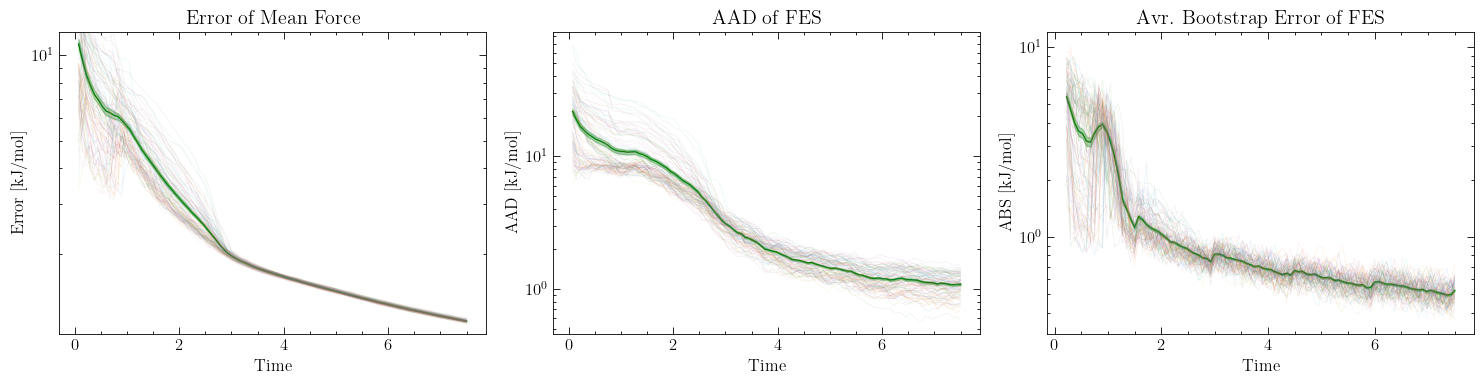

In [19]:
# Statistical Analysis of 100 long simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                                                                        return_results=True, plot=False, plot_log=True)
time_long, mean_ofe_long, ste_ofe_long, mean_aad_long, ste_aad_long, mean_abs_long, ste_abs_long = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
# plt.ylim(0, 20)

print(f"Mean Final AAD: {mean_aad_long[-1]:.4f} +- {ste_aad_long[-1]:.4f} || Mean Final ABS: {mean_abs_long[-1]:.4f} +- {ste_abs_long[-1]:.4f}")
plt.show()

### Run 100 Exploration simulations

In [6]:
# Run 100 exploration simulations
expl_sim_params = {**default_params}
expl_sim_params.update({"save_error_progression":True})#, "n_pos":2_500})
expl_sim_params.update({"simulation_steps":150_000, "metad_height":10, "biasfactor":200, "len_error_list":25})

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,101):
    
    sim_ID = f"_expl_{i_sim}"
    expl_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_expl = MFI_class2D.MFI2D(**expl_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_expl.run_simulation()
        MFI_expl.analyse_data()
        t, aofe, aad = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]
        
        print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(pot1 + MFI_expl.Bias):.4f}", end=" | ")
        # MFI_expl.plot_res()
        # lib2.plot_hills_trajectory(MFI_expl.hills)


    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 7.5478, AAD = 3.1763
Simulation 2 (exists) | Final Error: Aofe = 7.5382, AAD = 2.6640
Simulation 3 (exists) | Final Error: Aofe = 7.5493, AAD = 2.5729
Simulation 4 (exists) | Final Error: Aofe = 7.2052, AAD = 2.8882
Simulation 5 (exists) | Final Error: Aofe = 7.5125, AAD = 2.6608
Simulation 6 (exists) | Final Error: Aofe = 7.5539, AAD = 3.6531
Simulation 7 (exists) | Final Error: Aofe = 7.5406, AAD = 2.4827
Simulation 8 (exists) | Final Error: Aofe = 7.4519, AAD = 3.0157
Simulation 9 (exists) | Final Error: Aofe = 7.3599, AAD = 2.8502
Simulation 10 (exists) | Final Error: Aofe = 7.5247, AAD = 3.7245
Simulation 11 (exists) | Final Error: Aofe = 7.5098, AAD = 2.8607
Simulation 12 (exists) | Final Error: Aofe = 7.5638, AAD = 3.6625
Simulation 13 (exists) | Final Error: Aofe = 7.3747, AAD = 4.7007
Simulation 14 (exists) | Final Error: Aofe = 7.4854, AAD = 2.7328
Simulation 15 (exists) | Final Error: Aofe = 7.5334, AAD = 3.2869
Simulation 16 (exis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Final AAD: 3.0386 +- 0.0510


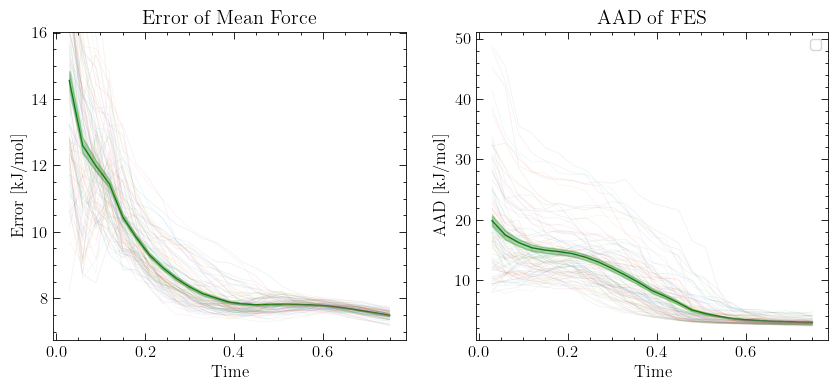

In [7]:
# Statistical Analysis of 100 exploration simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_expl[-1]:.4f} +- {ste_aad_expl[-1]:.4f}")

# plt.plot(t, aad_collection[88], label="run 88")
plt.legend(fontsize=10)
plt.show()


In [58]:
# # # Plot all exploration simulations to find a representative one to use for metad stage
# t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
# t = t_collection[0]

# for j in range(1, 21):
    
#     time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, return_results=True, plot=False, plot_log=False)
#     plt.subplot(1,2,1) 
#     for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
#     plt.subplot(1,2,2)
#     for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)    
    
#     for jj in range((j-1)*5, (j)*5):
        
#         print(f"Simulation {jj+1}", end=" | ")
        
#         plt.subplot(1,2,1)
#         plt.plot(t, aofe_collection[jj], label=f"{jj+1}", alpha=0.8)
#         plt.subplot(1,2,2)
#         plt.plot(t, aad_collection[jj], label=f"{jj+1}: {aad_collection[jj][-1]:.4f}", alpha=0.8)
    
#     print("")    
#     plt.legend(fontsize=10)
#     plt.yscale("log")
#     plt.show() 
                                                                                                        

Final Error: Aofe = 7.4954, AAD = 3.0398
MIN(FES+Bias) = 42.8075, MIN(Z+Bias) = 42.0365


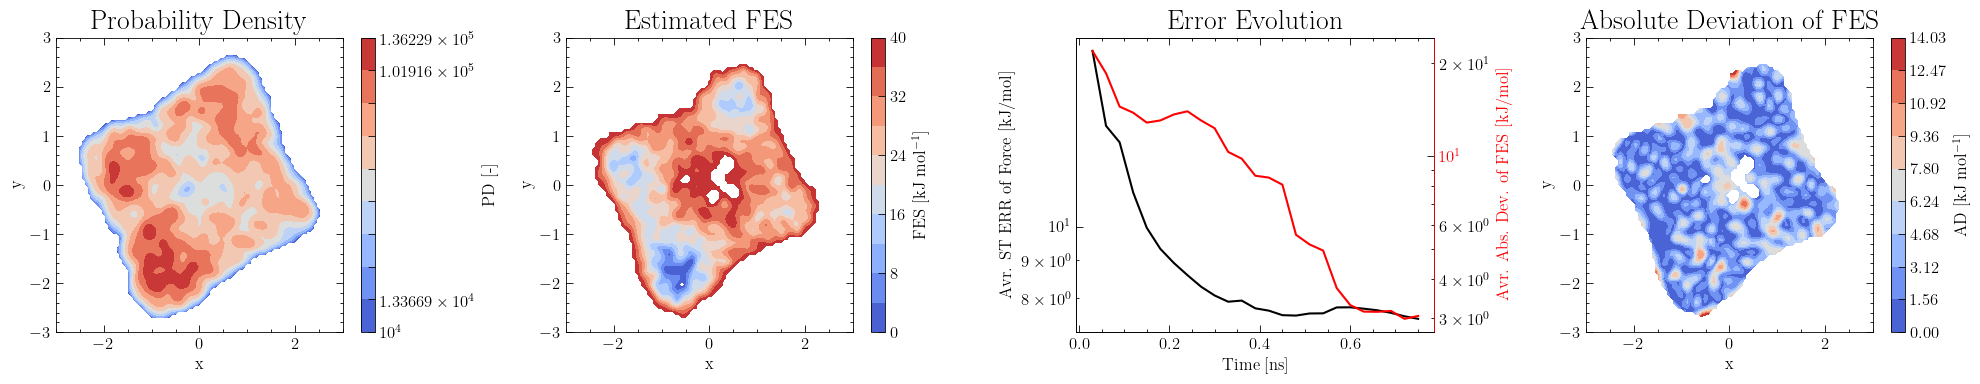

ready to show


In [7]:
# Exploration Simulation used for MetaD stage
new_params = {**default_params}
new_params.update({"ID":"_expl_74", "len_error_list":25, "save_results":True})

MFI_expl = MFI_class2D.MFI2D(**new_params)
MFI_expl.analyse_data()

print(F"Final Error: Aofe = {MFI_expl.Aofe:.4f}, AAD = {MFI_expl.AAD:.4f}")
print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(pot1 + MFI_expl.Bias):.4f}")

MFI_expl.plot_res(["AD"])
lib2.plot_3D_plotly(MFI_expl.X, MFI_expl.Y, MFI_expl.Z + MFI_expl.Bias, range_min=0, range_max=np.min(pot1 + MFI_expl.Bias)*2)
t_expl, v_expl, aofe_expl, aad_expl, abs_expl = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,1], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index], MFI_expl.Avr_Error_list[:, MFI_expl.abs_error_index]
force_terms_expl, sim_time_expl, fes_expl = MFI_expl.force_terms, MFI_expl.sim_time, MFI_expl.FES
forces_e_list_expl = MFI_expl.forces_e_list


### 2nd Stage - 1x MetaD simulation

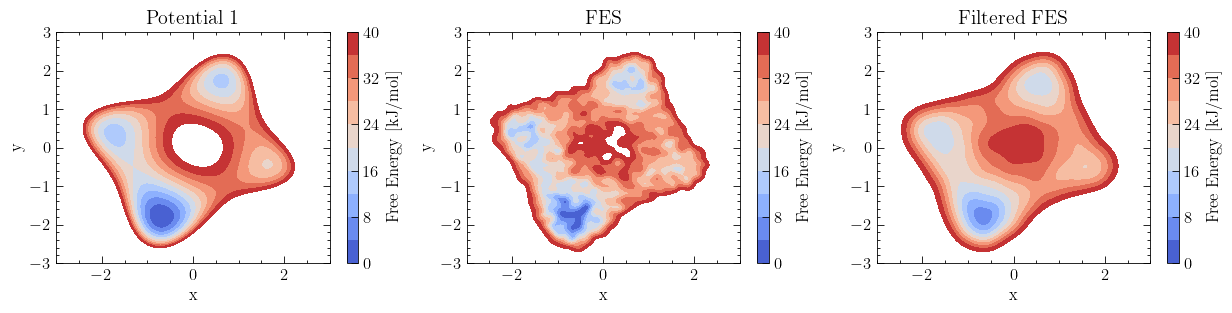

AAD FES: 2.6841
AAD FES_filtered: 2.3001


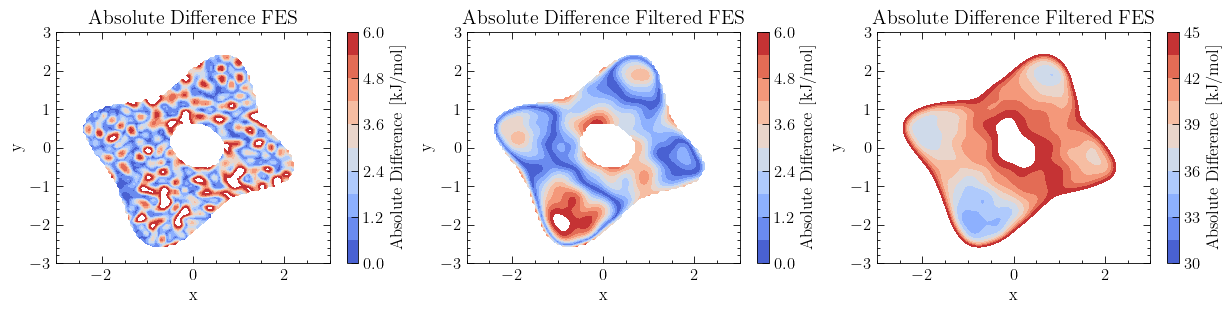

In [56]:
# plot the free energy surface and the filtered free energy surface and the AD and the potential + static bias
from scipy.ndimage import gaussian_filter
gfs = 3

fes = MFI_expl.FES
fes_filered = gaussian_filter(fes, sigma=gfs)

for _plot_ in [1]:
    plt.figure(figsize=(15,3))
    plt.subplot(1,3,1)
    plt.contourf(X, Y, pot1, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Potential 1")

    plt.subplot(1,3,2)
    plt.contourf(X, Y, fes, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("FES")

    plt.subplot(1,3,3)
    plt.contourf(X, Y, fes_filered, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Filtered FES")
    plt.show()

    plt.figure(figsize=(15,3))
    ad_fes = np.where(pot1 <= 40, np.abs(fes - pot1), 0)
    print(f"AAD FES: {np.sum(ad_fes)/(np.count_nonzero(ad_fes)):.4f}")
    plt.subplot(1,3,1)
    plt.contourf(X, Y, lib2.zero_to_nan(ad_fes), levels=np.linspace(0, 6, 11), cmap='coolwarm'); plt.colorbar(label="Absolute Difference [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Absolute Difference FES")

    ad_fes_filtered = np.where(pot1 <= 40, np.abs(fes_filered - pot1), 0)
    print(f"AAD FES_filtered: {np.sum(ad_fes_filtered)/(np.count_nonzero(ad_fes)):.4f}")

    plt.subplot(1,3,2)
    plt.contourf(X, Y, lib2.zero_to_nan(ad_fes_filtered), levels=np.linspace(0, 6, 11), cmap='coolwarm'); plt.colorbar(label="Absolute Difference [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Absolute Difference Filtered FES")
    
    bias, fx_bias, fy_bias, file_path_dat = lib2.make_external_bias_2D(X, Y, FES=fes, Bias_sf=1, gaus_filter_sigma=gfs, FES_cutoff=40, return_array=True)

    
    plt.subplot(1,3,3)
    plt.contourf(X, Y, pot1+bias, levels=np.linspace(30, 45, 11), cmap='coolwarm'); plt.colorbar(label="Absolute Difference [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Absolute Difference Filtered FES")
    plt.show()

In [7]:
## laod results from the exploration simulation
res = lib2.load_pkl(path_data + f"MFI_results_expl_74.pkl")[1]
force_terms_expl = res[0]
fes_expl = lib2.FFT_intg_2D(force_terms_expl[2], force_terms_expl[3], [-3,-3], [3, 3])
sim_time_expl = res[1].T[0][-1]
forces_e_list_expl = res[-1]


In [14]:
# Run 100 MetaD simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":1_350_000, "len_error_list":100, "save_error_progression":True, "save_results":True})
metad_sim_params.update({"metad_height":2, "biasfactor":5, "gaus_filter_sigma":3})
metad_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl, "base_forces_e_list":forces_e_list_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1, 101):
    
    sim_ID = f"_metad_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class2D.MFI2D(**metad_sim_params)
        MFI_metad.make_external_bias(FES=fes_expl)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_metad.run_simulation()
        MFI_metad.analyse_data()
        t, aofe, aad, aBS = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index], MFI_metad.Avr_Error_list[:, MFI_metad.abs_error_index]
        
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 3 | Final Error: Aofe = 1.5810, AAD = 0.6798, ABS = 0.4035
Simulation 4 | Final Error: Aofe = 1.5623, AAD = 0.7757, ABS = 0.3517
Simulation 5 | Final Error: Aofe = 1.5797, AAD = 0.8284, ABS = 0.3864
Simulation 6 | Final Error: Aofe = 1.5709, AAD = 0.8396, ABS = 0.4016
Simulation 7 | Final Error: Aofe = 1.5367, AAD = 0.8232, ABS = 0.3985
Simulation 8 | Final Error: Aofe = 1.5545, AAD = 0.8921, ABS = 0.4757
Simulation 9 | Final Error: Aofe = 1.5557, AAD = 0.6519, ABS = 0.4014
Simulation 10 | Final Error: Aofe = 1.5779, AAD = 1.1804, ABS = 0.3939
Simulation 11 | Final Error: Aofe = 1.5608, AAD = 0.9033, ABS = 0.4349
Simulation 12 | Final Error: Aofe = 1.5598, AAD = 0.7132, ABS = 0.3838
Simulation 13 | Final Error: Aofe = 1.5603, AAD = 0.7083, ABS = 0.4640
Simulation 14 | Final Error: Aofe = 1.5658, AAD = 0.6408, ABS = 0.3793
Simulation 15 | Final Error: Aofe = 1.5517, AAD = 0.7685, ABS = 0.4790
Simulation 16 | Final Error: Aofe = 1.5683, AAD = 0.8207, ABS = 0.3541
Simulation 17

Mean Final AAD: 0.7918 +- 0.0106 || Mean Final ABS: 0.4018 +- 0.0036


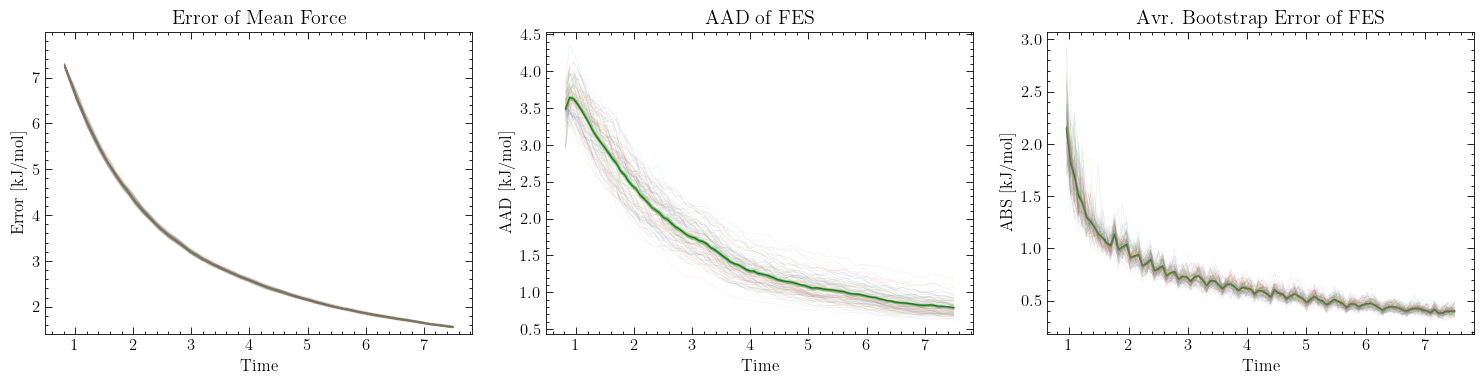

In [15]:
# Statistical Analysis of 100 MetaD simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, 
                                                return_results=True, plot=False, plot_log=False)
time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad, mean_abs_metad, ste_abs_metad = avr_results

plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metad[-1]:.4f} +- {ste_aad_metad[-1]:.4f} || Mean Final ABS: {mean_abs_metad[-1]:.4f} +- {ste_abs_metad[-1]:.4f}")
plt.show()

In [16]:

# Run 100 MetaD ALTERNATIVE simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":1_350_000, "len_error_list":100, "save_error_progression":True, "save_results":True})
metad_sim_params.update({"metad_height":2, "biasfactor":5, "gaus_filter_sigma":3})
metad_sim_params.update({"base_forces":None, "base_time":sim_time_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1, 101):
    
    sim_ID = f"_metad_{i_sim}"
    sim_ID_ALT = f"_metadALT_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID_ALT}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID_ALT}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class2D.MFI2D(**metad_sim_params)
        MFI_metad.make_external_bias(FES=fes_expl)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_metad.run_simulation()
        MFI_metad.ID = sim_ID_ALT
        MFI_metad.analyse_data()
        t, aofe, aad, aBS = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index], MFI_metad.Avr_Error_list[:, MFI_metad.abs_error_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 3 | Final Error: Aofe = 0.9741, AAD = 0.5863, ABS = 0.2359
Simulation 4 | Final Error: Aofe = 0.9626, AAD = 0.5313, ABS = 0.1932
Simulation 5 | Final Error: Aofe = 0.9704, AAD = 0.5439, ABS = 0.2102
Simulation 6 | Final Error: Aofe = 0.9722, AAD = 0.5649, ABS = 0.2237
Simulation 7 | Final Error: Aofe = 0.9524, AAD = 0.5794, ABS = 0.1769
Simulation 8 | Final Error: Aofe = 0.9685, AAD = 0.5508, ABS = 0.2148
Simulation 9 | Final Error: Aofe = 0.9623, AAD = 0.5720, ABS = 0.2221
Simulation 10 | Final Error: Aofe = 0.9760, AAD = 0.7602, ABS = 0.2133
Simulation 11 | Final Error: Aofe = 0.9601, AAD = 0.5782, ABS = 0.2004
Simulation 12 | Final Error: Aofe = 0.9655, AAD = 0.5360, ABS = 0.2065
Simulation 13 | Final Error: Aofe = 0.9618, AAD = 0.5675, ABS = 0.2416
Simulation 14 | Final Error: Aofe = 0.9668, AAD = 0.5448, ABS = 0.1977
Simulation 15 | Final Error: Aofe = 0.9523, AAD = 0.5477, ABS = 0.2192
Simulation 16 | Final Error: Aofe = 0.9687, AAD = 0.5533, ABS = 0.1781
Simulation 17

Mean Final AAD: 0.5660 +- 0.0039  || Mean Final ABS: 0.2113 +- 0.0022


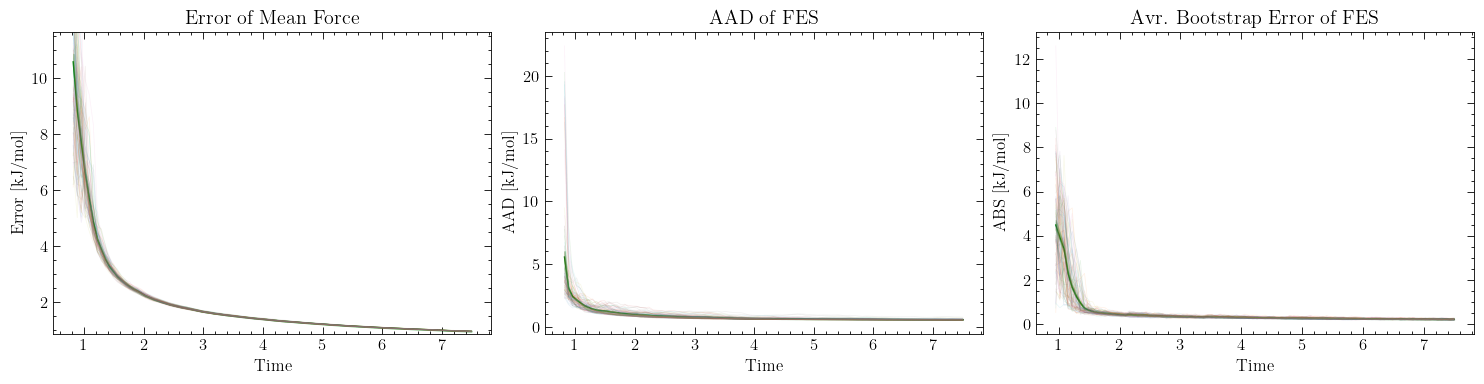

In [17]:
# Statistical Analysis of 100 MetaD ALTERNATIVE simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                return_results=True, plot=False, plot_log=False)
time_metadALT, mean_ofe_metadALT, ste_ofe_metadALT, mean_aad_metadALT, ste_aad_metadALT, mean_abs_metadALT, ste_abs_metadALT = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadALT[-1]:.4f} +- {ste_aad_metadALT[-1]:.4f}  || Mean Final ABS: {mean_abs_metadALT[-1]:.4f} +- {ste_abs_metadALT[-1]:.4f}")
plt.show()

### 2nd Stage - 2x MetaD simulations

In [11]:
# Patching of 50x2 MetaD simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"len_error_list":100})
metadx2_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl, "base_forces_e_list":forces_e_list_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2_{n_camp}"
    metadx2_sim_params.update({"ID":camp_ID})
    
    if 1==2 and os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class2D.MFI2D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, v, aofe, aad, aBS = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,1], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.abs_error_index]
        lib2.save_pkl(np.array([t, v, aofe, aad, aBS]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")

Analysis 1 | Final Error: Aofe = 1.2064, AAD = 0.9991, ABS = 0.3534
Analysis 2 | Final Error: Aofe = 1.2093, AAD = 0.7057, ABS = 0.3225
Analysis 3 | Final Error: Aofe = 1.2104, AAD = 0.8388, ABS = 0.3420
Analysis 4 | Final Error: Aofe = 1.1898, AAD = 0.8522, ABS = 0.2831
Analysis 5 | Final Error: Aofe = 1.2057, AAD = 0.7629, ABS = 0.2952
Analysis 6 | Final Error: Aofe = 1.1966, AAD = 0.7989, ABS = 0.3089
Analysis 7 | Final Error: Aofe = 1.1871, AAD = 0.7171, ABS = 0.3263
Analysis 8 | Final Error: Aofe = 1.2131, AAD = 0.7857, ABS = 0.3283
Analysis 9 | Final Error: Aofe = 1.1944, AAD = 0.7046, ABS = 0.2937
Analysis 10 | Final Error: Aofe = 1.1996, AAD = 0.8858, ABS = 0.3274
Analysis 11 | Final Error: Aofe = 1.1961, AAD = 0.6790, ABS = 0.2956
Analysis 12 | Final Error: Aofe = 1.1968, AAD = 0.8943, ABS = 0.2833
Analysis 13 | Final Error: Aofe = 1.1938, AAD = 0.6337, ABS = 0.3121
Analysis 14 | Final Error: Aofe = 1.2044, AAD = 0.9389, ABS = 0.3360
Analysis 15 | Final Error: Aofe = 1.1997, A

Mean Final AAD: 0.7620 +- 0.0120


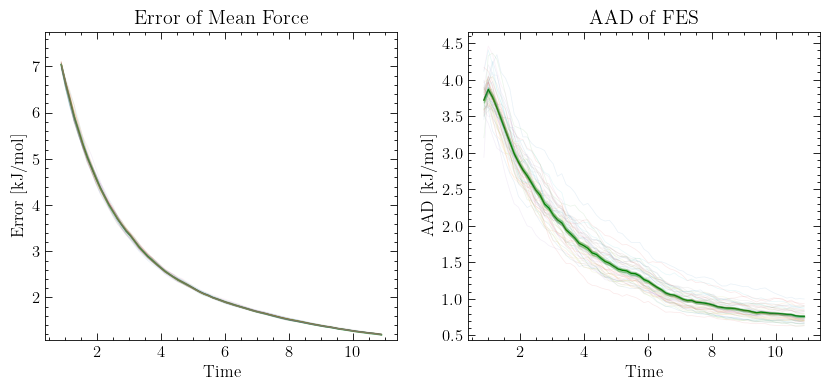

In [76]:
# Statistical Analysis of 50x2 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx2, mean_ofe_metadx2, ste_ofe_metadx2, mean_aad_metadx2, ste_aad_metadx2 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx2[-1]:.4f} +- {ste_aad_metadx2[-1]:.4f}")
plt.show()

In [12]:
# Patching of 50x2 MetaD simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"len_error_list":100})
metadx2_sim_params.update({"base_forces":None, "base_time":sim_time_expl, "base_forces_e_list":None})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2ALT_{n_camp}"
    metadx2_sim_params.update({"ID":camp_ID})
    
    if 1==2 and os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class2D.MFI2D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, v, aofe, aad, aBS = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,1], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.abs_error_index]
        lib2.save_pkl(np.array([t, v, aofe, aad, aBS]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")

Analysis 1 | Final Error: Aofe = 0.8340, AAD = 0.6443, ABS = 0.2355
Analysis 2 | Final Error: Aofe = 0.8378, AAD = 0.5216, ABS = 0.2312
Analysis 3 | Final Error: Aofe = 0.8374, AAD = 0.5846, ABS = 0.2289
Analysis 4 | Final Error: Aofe = 0.8305, AAD = 0.6180, ABS = 0.1842
Analysis 5 | Final Error: Aofe = 0.8341, AAD = 0.5680, ABS = 0.1982
Analysis 6 | Final Error: Aofe = 0.8272, AAD = 0.5469, ABS = 0.2031
Analysis 7 | Final Error: Aofe = 0.8216, AAD = 0.5312, ABS = 0.2152
Analysis 8 | Final Error: Aofe = 0.8369, AAD = 0.5322, ABS = 0.2099
Analysis 9 | Final Error: Aofe = 0.8299, AAD = 0.5400, ABS = 0.1619
Analysis 10 | Final Error: Aofe = 0.8312, AAD = 0.6880, ABS = 0.2147
Analysis 11 | Final Error: Aofe = 0.8268, AAD = 0.5208, ABS = 0.1877
Analysis 12 | Final Error: Aofe = 0.8336, AAD = 0.6471, ABS = 0.2168
Analysis 13 | Final Error: Aofe = 0.8266, AAD = 0.5399, ABS = 0.1613
Analysis 14 | Final Error: Aofe = 0.8353, AAD = 0.5596, ABS = 0.2042
Analysis 15 | Final Error: Aofe = 0.8338, A

### 2nd Stage - 3x MetaD simulations

In [77]:
# Patching of 33x3 MetaD simulations
metadx3_sim_params = {**default_params}
metadx3_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx3_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 3
parallel_efficiency = 0.667

for n_camp in range(1, 34):
    
    camp_ID = f"_metadx3_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx3 = MFI_class2D.MFI2D(**metadx3_sim_params)
        MFI_metadx3.make_external_bias(FES=fes_expl)
        mfi_parallel_x3 = MFI_metadx3.MFI_parallel(parent=MFI_metadx3, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x3.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x3.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x3.patch_simulations()
        t, aofe, aad = MFI_metadx3.Avr_Error_list[:,0], MFI_metadx3.Avr_Error_list[:,2], MFI_metadx3.Avr_Error_list[:, MFI_metadx3.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 1.0053, AAD = 0.8879
Analysis 2 | Final Error: Aofe = 1.0035, AAD = 0.7339
Analysis 3 | Final Error: Aofe = 0.9973, AAD = 0.6359
Analysis 4 | Final Error: Aofe = 1.0053, AAD = 0.9052
Analysis 5 | Final Error: Aofe = 1.0024, AAD = 0.6730
Analysis 6 | Final Error: Aofe = 1.0104, AAD = 0.6859
Analysis 7 | Final Error: Aofe = 0.9970, AAD = 0.7872
Analysis 8 | Final Error: Aofe = 1.0034, AAD = 0.8217
Analysis 9 | Final Error: Aofe = 1.0036, AAD = 0.6759
Analysis 10 | Final Error: Aofe = 1.0037, AAD = 0.7876
Analysis 11 | Final Error: Aofe = 1.0011, AAD = 0.6766
Analysis 12 | Final Error: Aofe = 1.0008, AAD = 0.7553
Analysis 13 | Final Error: Aofe = 0.9975, AAD = 0.8414
Analysis 14 | Final Error: Aofe = 0.9996, AAD = 0.6492
Analysis 15 | Final Error: Aofe = 0.9965, AAD = 0.6565
Analysis 16 | Final Error: Aofe = 1.0015, AAD = 0.7746
Analysis 17 | Final Error: Aofe = 1.0065, AAD = 0.6929
Analysis 18 | Final Error: Aofe = 1.0035, AAD = 0.6493
Analysis 19 | Final

Mean Final AAD: 0.7166 +- 0.0142


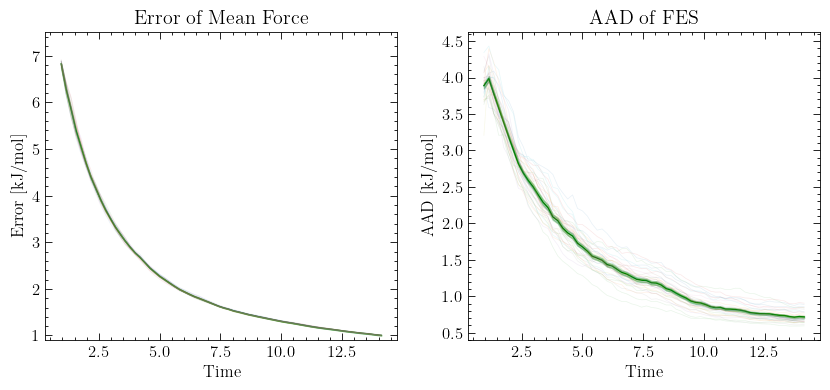

In [78]:
# Statistical Analysis of 33x3 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx3, mean_ofe_metadx3, ste_ofe_metadx3, mean_aad_metadx3, ste_aad_metadx3 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### 2nd Stage - 4x MetaD simulations

In [79]:
# Patching of 25x4 MetaD simulations
metadx4_sim_params = {**default_params}
# metadx4_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx4_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 4
parallel_efficiency = 0.5

for n_camp in range(1, 26):
    
    camp_ID = f"_metadx4_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx4 = MFI_class2D.MFI2D(**metadx4_sim_params)
        MFI_metadx4.make_external_bias(FES=fes_expl)
        mfi_parallel_x4 = MFI_metadx4.MFI_parallel(parent=MFI_metadx4, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x4.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x4.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x4.patch_simulations()
        t, aofe, aad = MFI_metadx4.Avr_Error_list[:,0], MFI_metadx4.Avr_Error_list[:,2], MFI_metadx4.Avr_Error_list[:, MFI_metadx4.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")



Analysis 1 | Final Error: Aofe = 1.0155, AAD = 0.8175
Analysis 2 | Final Error: Aofe = 1.0084, AAD = 0.7602
Analysis 3 | Final Error: Aofe = 1.0200, AAD = 0.7350
Analysis 4 | Final Error: Aofe = 1.0229, AAD = 0.7319
Analysis 5 | Final Error: Aofe = 1.0062, AAD = 0.8232
Analysis 6 | Final Error: Aofe = 1.0124, AAD = 0.7237
Analysis 7 | Final Error: Aofe = 1.0106, AAD = 0.8430
Analysis 8 | Final Error: Aofe = 1.0143, AAD = 0.8251
Analysis 9 | Final Error: Aofe = 1.0091, AAD = 0.7851
Analysis 10 | Final Error: Aofe = 0.9998, AAD = 0.9265
Analysis 11 | Final Error: Aofe = 1.0022, AAD = 0.7241
Analysis 12 | Final Error: Aofe = 1.0132, AAD = 0.7192
Analysis 13 | Final Error: Aofe = 1.0126, AAD = 0.7319
Analysis 14 | Final Error: Aofe = 1.0050, AAD = 0.7196
Analysis 15 | Final Error: Aofe = 1.0052, AAD = 0.7424
Analysis 16 | Final Error: Aofe = 1.0089, AAD = 0.7798
Analysis 17 | Final Error: Aofe = 1.0098, AAD = 0.6500
Analysis 18 | Final Error: Aofe = 1.0151, AAD = 0.7719
Analysis 19 | Final

Mean Final AAD: 0.7556 +- 0.0118


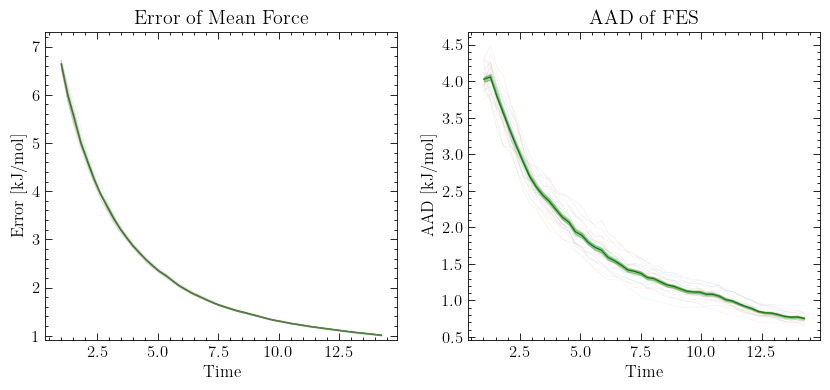

In [80]:
# Statistical Analysis of 25x4 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx4, mean_ofe_metadx4, ste_ofe_metadx4, mean_aad_metadx4, ste_aad_metadx4 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx4[-1]:.4f} +- {ste_aad_metadx4[-1]:.4f}")
plt.show()

### 2nd Stage 6x MetaD simulation

In [81]:
# Patching of 16x6 MetaD simulations
metadx6_sim_params = {**default_params}
# metadx6_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx6_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 6
parallel_efficiency = 0.4

for n_camp in range(1, 17):
    
    camp_ID = f"_metadx6_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx6 = MFI_class2D.MFI2D(**metadx6_sim_params)
        MFI_metadx6.make_external_bias(FES=fes_expl)
        mfi_parallel_x6 = MFI_metadx6.MFI_parallel(parent=MFI_metadx6, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x6.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x6.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x6.patch_simulations()
        t, aofe, aad = MFI_metadx6.Avr_Error_list[:,0], MFI_metadx6.Avr_Error_list[:,2], MFI_metadx6.Avr_Error_list[:, MFI_metadx6.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 0.9073, AAD = 0.9422
Analysis 2 | Final Error: Aofe = 0.9002, AAD = 0.8360
Analysis 3 | Final Error: Aofe = 0.9043, AAD = 0.7924
Analysis 4 | Final Error: Aofe = 0.8961, AAD = 0.8719
Analysis 5 | Final Error: Aofe = 0.8976, AAD = 0.9701
Analysis 6 | Final Error: Aofe = 0.8992, AAD = 0.9089
Analysis 7 | Final Error: Aofe = 0.8913, AAD = 0.9618
Analysis 8 | Final Error: Aofe = 0.8957, AAD = 0.8064
Analysis 9 | Final Error: Aofe = 0.8985, AAD = 0.8059
Analysis 10 | Final Error: Aofe = 0.8907, AAD = 0.8518
Analysis 11 | Final Error: Aofe = 0.8985, AAD = 0.8667
Analysis 12 | Final Error: Aofe = 0.8954, AAD = 0.7825
Analysis 13 | Final Error: Aofe = 0.9049, AAD = 0.8276
Analysis 14 | Final Error: Aofe = 0.8948, AAD = 0.7865
Analysis 15 | Final Error: Aofe = 0.9003, AAD = 0.8189
Analysis 16 | Final Error: Aofe = 0.8979, AAD = 0.7970


Mean Final AAD: 0.8517 +- 0.0153


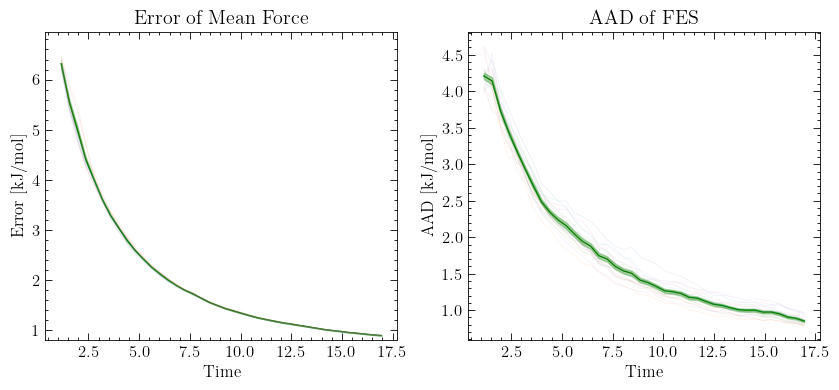

In [82]:
# Statistical Analysis of 16x6 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx6, mean_ofe_metadx6, ste_ofe_metadx6, mean_aad_metadx6, ste_aad_metadx6 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx6[-1]:.4f} +- {ste_aad_metadx6[-1]:.4f}")
plt.show()

### 2nd Stage 10x MetaD simulation

In [83]:
# Patching of 10x10 MetaD simulations
metadx10_sim_params = {**default_params}
# metadx10_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx10_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 10
parallel_efficiency = 0.3

for n_camp in range(1, 11):
    
    camp_ID = f"_metadx10_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx10 = MFI_class2D.MFI2D(**metadx10_sim_params)
        MFI_metadx10.make_external_bias(FES=fes_expl)
        mfi_parallel_x10 = MFI_metadx10.MFI_parallel(parent=MFI_metadx10, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x10.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x10.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x10.patch_simulations()
        t, aofe, aad = MFI_metadx10.Avr_Error_list[:,0], MFI_metadx10.Avr_Error_list[:,2], MFI_metadx10.Avr_Error_list[:, MFI_metadx10.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 0.7923, AAD = 0.9961
Analysis 2 | Final Error: Aofe = 0.7879, AAD = 0.9976
Analysis 3 | Final Error: Aofe = 0.7853, AAD = 0.9784
Analysis 4 | Final Error: Aofe = 0.7842, AAD = 1.0501
Analysis 5 | Final Error: Aofe = 0.7763, AAD = 0.9296
Analysis 6 | Final Error: Aofe = 0.7823, AAD = 0.9561
Analysis 7 | Final Error: Aofe = 0.7831, AAD = 0.8282
Analysis 8 | Final Error: Aofe = 0.7872, AAD = 0.9671
Analysis 9 | Final Error: Aofe = 0.7846, AAD = 0.8598
Analysis 10 | Final Error: Aofe = 0.7900, AAD = 0.8392


Mean Final AAD: 0.9402 +- 0.0224


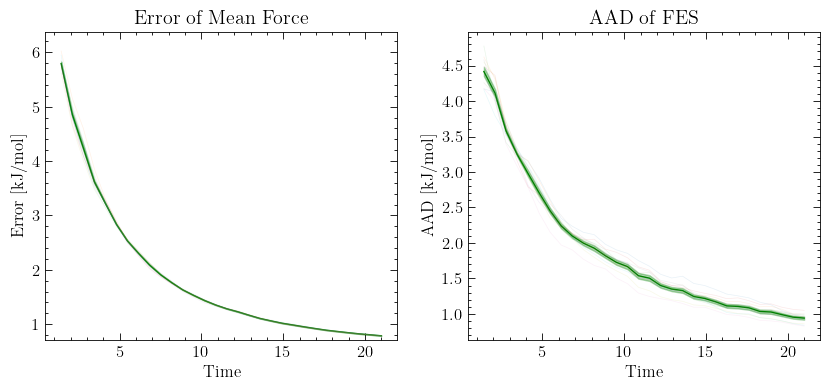

In [84]:
# Statistical Analysis of 10x10 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx10, mean_ofe_metadx10, ste_ofe_metadx10, mean_aad_metadx10, ste_aad_metadx10 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx10[-1]:.4f} +- {ste_aad_metadx10[-1]:.4f}")
plt.show()

### Compare Convergence of Simulations

In [29]:
# import gaussian_filter
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    # if window_length is None: window_length = int(len(data)/10)
    # if polyorder is None: polyorder = 2
    # return savgol_filter(data, window_length, polyorder)
    return data


In [4]:
### laod results

# long simulation
t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
for i_sim in range(1,21):
    t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_long_{i_sim}.pkl")
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
time_long, mean_ofe_long, ste_ofe_long, mean_aad_long, ste_aad_long, mean_abs_long, ste_abs_long = avr_results
plt.close()

# exploration simulation
t_expl, _, aofe_expl, aad_expl, abs_expl = lib2.load_pkl(path_data + f"MFI_results_expl_74.pkl")[1][1].T

# metad simulation
t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
for i_sim in range(1,101):
    t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metad_{i_sim}.pkl")
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad, mean_abs_metad, ste_abs_metad = avr_results
plt.close()

# metad ALTERNATIVE simulation
t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
for i_sim in range(1,101):
    t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metadALT_{i_sim}.pkl")
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
time_metadALT, mean_ofe_metadALT, ste_ofe_metadALT, mean_aad_metadALT, ste_aad_metadALT, mean_abs_metadALT, ste_abs_metadALT = avr_results
plt.close()

# # metadx2 ALTERNATIVE simulation
# t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
# for i_sim in range(1,51):
#     t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metadx2_{i_sim}.pkl")
#     t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
# avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
# time_metadx2, mean_ofe_metadx2, ste_ofe_metadx2, mean_aad_metadx2, ste_aad_metadx2, mean_abs_metadx2, ste_abs_metadx2 = avr_results
# plt.close()

# # metadx2 ALTERNATIVE simulation
# t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
# for i_sim in range(1,51):
#     t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metadx2ALT_{i_sim}.pkl")
#     t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
# avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
# time_metadx2ALT, mean_ofe_metadx2ALT, ste_ofe_metadx2ALT, mean_aad_metadx2ALT, ste_aad_metadx2ALT, mean_abs_metadx2ALT, ste_abs_metadx2ALT = avr_results
# plt.close()

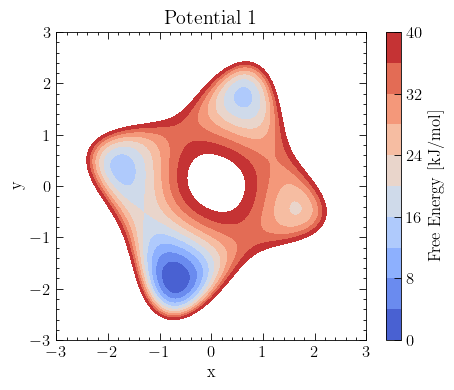

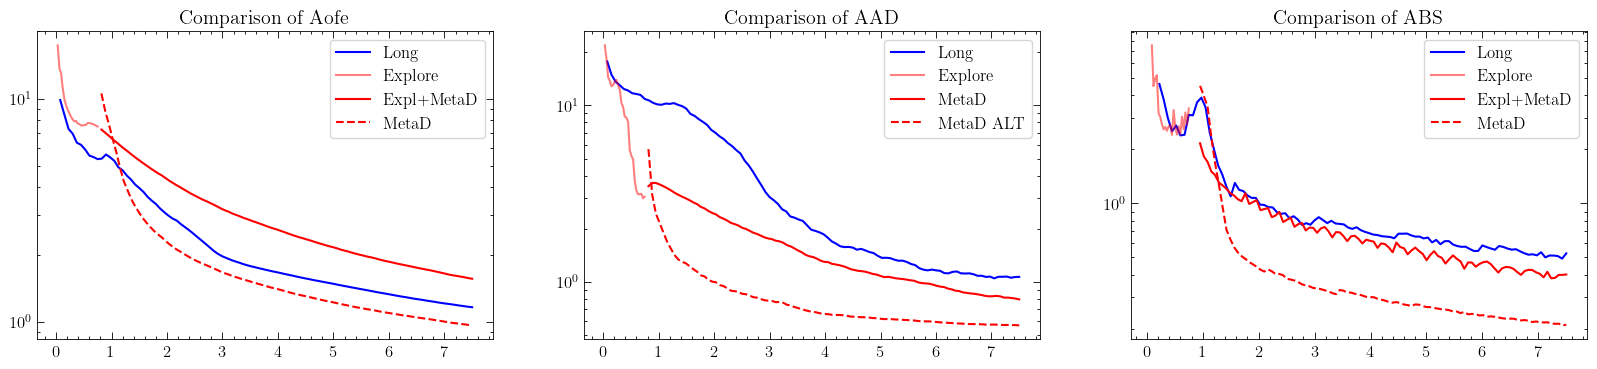

In [5]:
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    # if window_length is None: window_length = int(len(data)/10)
    # if polyorder is None: polyorder = 2
    # return savgol_filter(data, window_length, polyorder)
    return data
    
plt.figure(figsize=(5,4))
plt.contourf(X, Y, pot1, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Potential 1"); plt.show()


plt.figure(figsize=(20,4))
# time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

plt.subplot(1,3,1)
plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_ofe_metad, label="Expl+MetaD", color="red")
plt.plot(time_metadALT, mean_ofe_metadALT, label="MetaD", color="red", linestyle="--")
# plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
# plt.plot(time_metadx2ALT, mean_ofe_metadx2ALT, label="Expl+MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,3,2)
plt.plot(time_long, sf(mean_aad_long), label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
plt.plot(t_expl, aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_aad_metad), label="MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadALT, sf(mean_aad_metadALT), label="MetaD ALT", color="red", linestyle="--");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
# plt.plot(time_metadx2, sf(mean_aad_metadx2), label="MetaDx2", color="orange")
# plt.plot(time_metadx2, sf(mean_aad_metadx2ALT), label="MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
# plt.plot(time_metadx4, sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, sf(mean_aad_metadx10), label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of AAD"); 
# plt.xlim(0,10)

plt.subplot(1,3,3)
plt.plot(time_long, sf(mean_abs_long), label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
plt.plot(t_expl, abs_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_abs_metad), label="Expl+MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadALT, sf(mean_abs_metadALT), label="MetaD", color="red", linestyle="--");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
# plt.plot(time_metadx2, sf(mean_abs_metadx2), label="Expl+MetaDx2", color="orange")
# plt.plot(time_metadx2ALT, sf(mean_abs_metadx2ALT), label="MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
# plt.plot(time_metadx4, sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, sf(mean_aad_metadx10), label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of ABS"); 
# plt.ylim(0.38, 0.6)

plt.show()



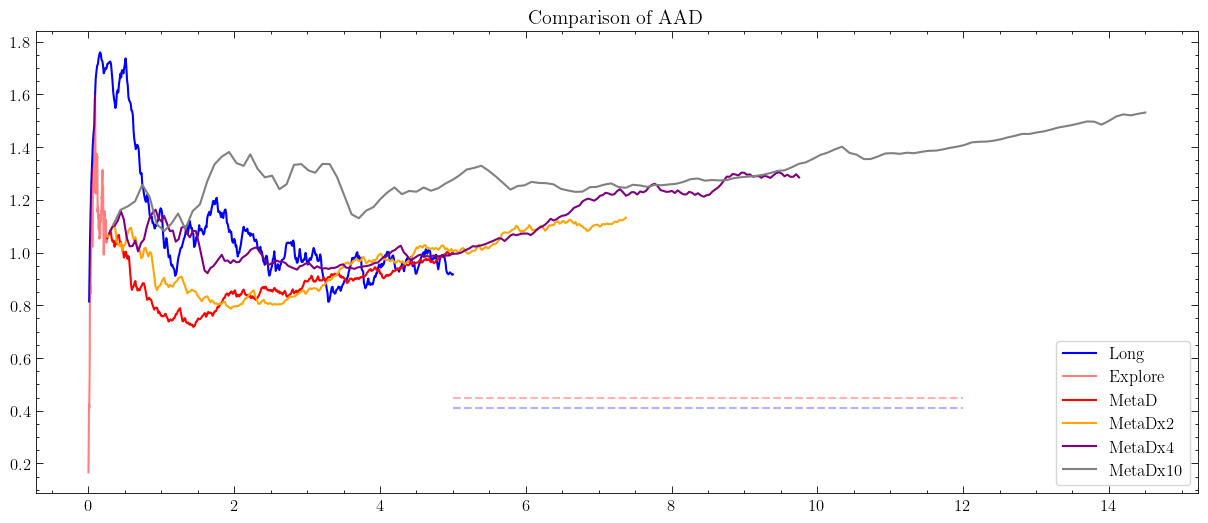

In [22]:
plt.figure(figsize=(15,6))
# plt.figure(figsize=(20,4))
# # time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

# plt.subplot(1,2,1)
# plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# # plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
# plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
# plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
# plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
# # plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# # plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
# plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

# plt.subplot(1,2,2)
plt.plot(time_long, np.sqrt(time_long)*sf(mean_aad_long), label="Long", color="blue"); plt.plot([time_long[-1], 12], [mean_aad_long[-1],mean_aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, np.sqrt(t_expl)*sf(aad_expl), label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, np.sqrt(time_metad)*sf(mean_aad_metad), label="MetaD", color="red"); plt.plot([time_metad[-1], 12], [mean_aad_metad[-1],mean_aad_metad[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadx2, np.sqrt(time_metadx2)*sf(mean_aad_metadx2), label="MetaDx2", color="orange")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
plt.plot(time_metadx4, np.sqrt(time_metadx4)*sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
plt.plot(time_metadx10, np.sqrt(time_metadx10)*mean_aad_metadx10, label="MetaDx10", color="grey")

# plt.ylim(0.38, 3)
# plt.xlim(0, 5)
# plt.yscale("log"); 
plt.legend(); plt.title("Comparison of AAD"); plt.show()